## This notebook measures performance improvements of mixed-precision FNO

In [2]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [3]:
import numpy as np
import matplotlib.pyplot as plt



In [38]:
def plot_memory_savings(memory_consumptions, labels, save_name=None):
    plt.figure(figsize=(12, 6))

    x = np.arange(len(memory_consumptions))
    colors = plt.cm.get_cmap('Set3', len(memory_consumptions))

    # Find the index of the slowest method
    largest_idx = np.argmax(memory_consumptions)
    largest_memory = memory_consumptions[largest_idx]

    # Calculate reduction percentage for each method
    reductions = [(largest_memory - t) / largest_memory * 100 for t in memory_consumptions]

    # Sort memory_consumptions and labels based on slowest to fastest
    memory_consumptions_sorted, labels_sorted, reductions_sorted = zip(*sorted(zip(memory_consumptions, labels, reductions), reverse=True))

    bars = plt.bar(x, memory_consumptions_sorted, color=colors(x))
    plt.xticks(x, labels_sorted, rotation='horizontal', fontsize=16)
    #plt.xlabel('Methods', fontsize=18)
    plt.ylabel('GPU Memory Consumption (MB)', fontsize=18)
    plt.title('Comparison of GPU Memory Consumption', fontsize=20)
    plt.grid(False)

    # Add text on top of each bar
    for i, bar in enumerate(bars):
        height = bar.get_height()
        plt.text(bar.get_x() + bar.get_width() / 2, height,
                 f'{reductions_sorted[i]:.1f}%', ha='center', va='bottom', fontsize=16)

    plt.tight_layout()
    if save_name:
        plt.savefig(save_name, format='pdf')

    plt.show()

In [26]:
def plot_throughput(throughputs, labels, save_name=None):
    plt.figure(figsize=(12, 6))
    x = np.arange(len(throughputs))
    #x = np.arange(1, len(throughputs), 0.9)
    colors = plt.cm.get_cmap('Set3', len(throughputs))

    # Find the index of the slowest method
    smallest_idx = np.argmin(throughputs)
    smallest_throughput = throughputs[smallest_idx]

    reductions = [(t - smallest_throughput) / smallest_throughput * 100 for t in throughputs]

    throughputs_sorted, labels_sorted, reductions_sorted = zip(*sorted(zip(throughputs, labels, reductions), reverse=False))

    #group these bars together
    bars = plt.bar(x, throughputs_sorted, color=colors(x))
    plt.xticks(x, labels_sorted, rotation='horizontal', fontsize=16)
    #plt.xlabel('Methods', fontsize=18)
    plt.ylabel('Training Throughput (samples/s)', fontsize=18)
    plt.title('Comparison of Training Throughput', fontsize=20)
    plt.grid(False)

    # Add text on top of each bar
    for i, bar in enumerate(bars):
        height = bar.get_height()
        plt.text(bar.get_x() + bar.get_width() / 2, height,
                 f'{reductions_sorted[i]:.1f}%', ha='center', va='bottom', fontsize=16)

    plt.tight_layout()
    if save_name:
        plt.savefig(save_name, format='pdf')

    plt.show()

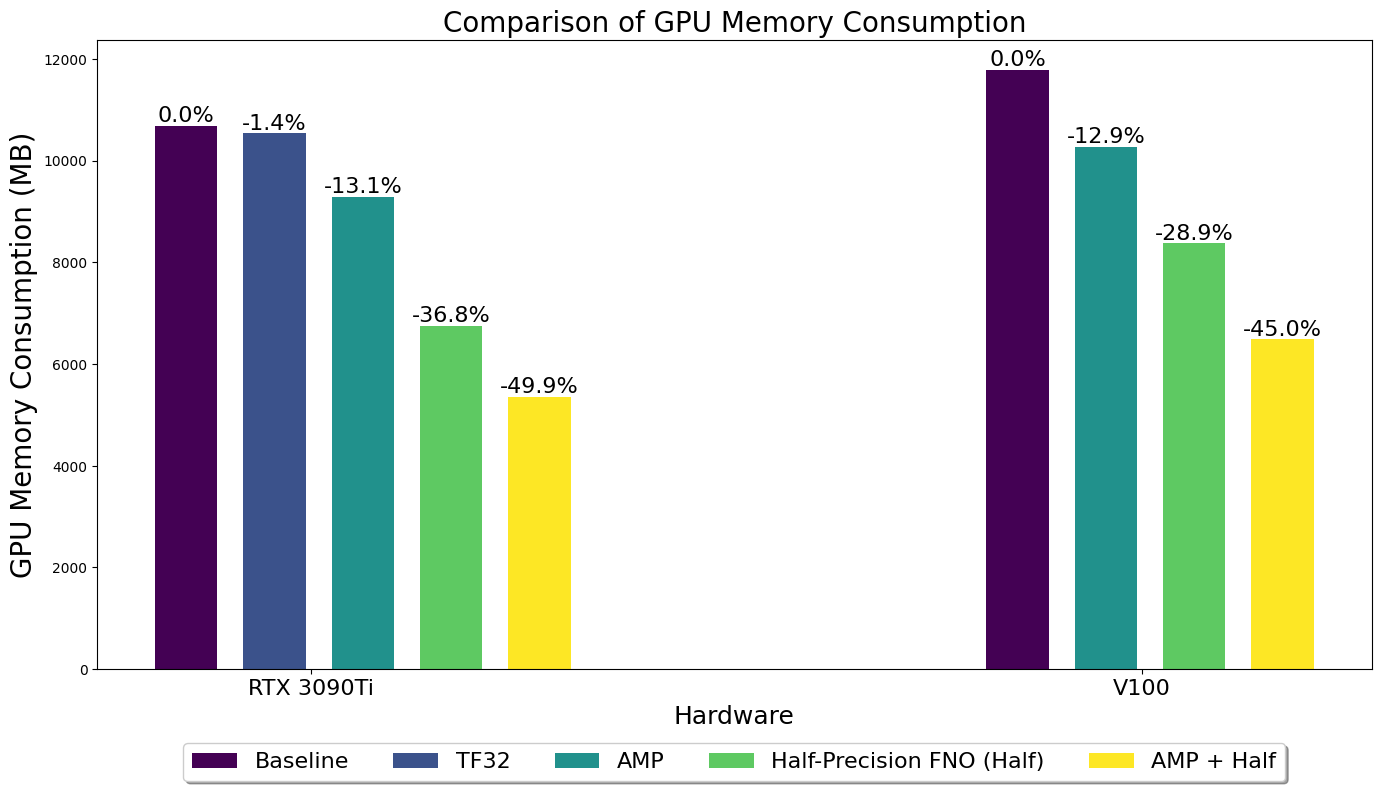

In [13]:
def plot_memory_hardware(memory_3090, memory_v100, labels_3090, labels_v100, save_name=None):
    plt.figure(figsize=(14, 8))
    num_methods = len(labels_3090)
    num_hardware = 2
    
    bar_width = 0.06
    colors = plt.cm.get_cmap('viridis', len(labels_3090))
    hardware_labels = ['RTX 3090Ti', 'V100']
    index = np.arange(num_hardware)

    # Plot each method's bars with distinct color
    for i, memory in enumerate(memory_3090):
        bars = plt.bar(i * bar_width+ 0.025*i, memory, bar_width, label=labels_3090[i], color=colors(i))
        for i, bar in enumerate(bars):
            height = bar.get_height()
            plt.text(bar.get_x() + bar.get_width() / 2, height,
                     f'{(height-memory_3090[i])/memory_3090[i]*100:.1f}%', ha='center', va='bottom', fontsize=16)
    
    for i, runtimes in enumerate(memory_v100):
        if i:
            color_index = i + 1
        else:
            color_index = i
        bars_v100 = plt.bar(0.8 + i * bar_width+ 0.025*i, runtimes, bar_width, color=colors(color_index))
        for i, bar in enumerate(bars_v100):
            height = bar.get_height()
            plt.text(bar.get_x() + bar.get_width() / 2, height,
                     f'{(height-memory_v100[i])/memory_v100[i]*100:.1f}%', ha='center', va='bottom', fontsize=16)
    

    # Adjust x-ticks and labels
    plt.xticks(index * 0.8 + bar_width * (num_methods - 1) / 2, hardware_labels, rotation='horizontal', fontsize=16)
    plt.xlabel('Hardware', fontsize=18)
    plt.ylabel('GPU Memory Consumption (MB)', fontsize=20)
    plt.title('Comparison of GPU Memory Consumption', fontsize=20)
    plt.grid(False)
    plt.legend(fontsize=16)
    #put legend in middle in the plot 
    plt.legend(loc='upper center', bbox_to_anchor=(0.5, -0.1), fancybox=True, shadow=True, ncol=5, fontsize=16)
    
    if save_name is not None:
        plt.savefig(save_name, bbox_inches='tight', format='pdf')

    plt.tight_layout()
    plt.show()

volta_memory = [11781, 10265, 8373, 6483]
ampere_memory = [10686, 10534, 9284, 6750, 5350]
ampere_labels = ['Baseline', 'TF32', 'AMP', 'Half-Prec FNO(Half)', 'AMP + Half']
volta_labels = ['Baseline', 'AMP', 'Half-Prec FNO(Half)', 'AMP + Half']


plot_memory_hardware(ampere_memory, volta_memory, ['Baseline', 'TF32', 'AMP', 'Half-Precision FNO (Half)', 'AMP + Half'], ['Baseline', 'AMP', 'Half-Precision FNO (Half)', 'AMP + Half'],
                      save_name='ampere_vs_volta_memory.pdf')

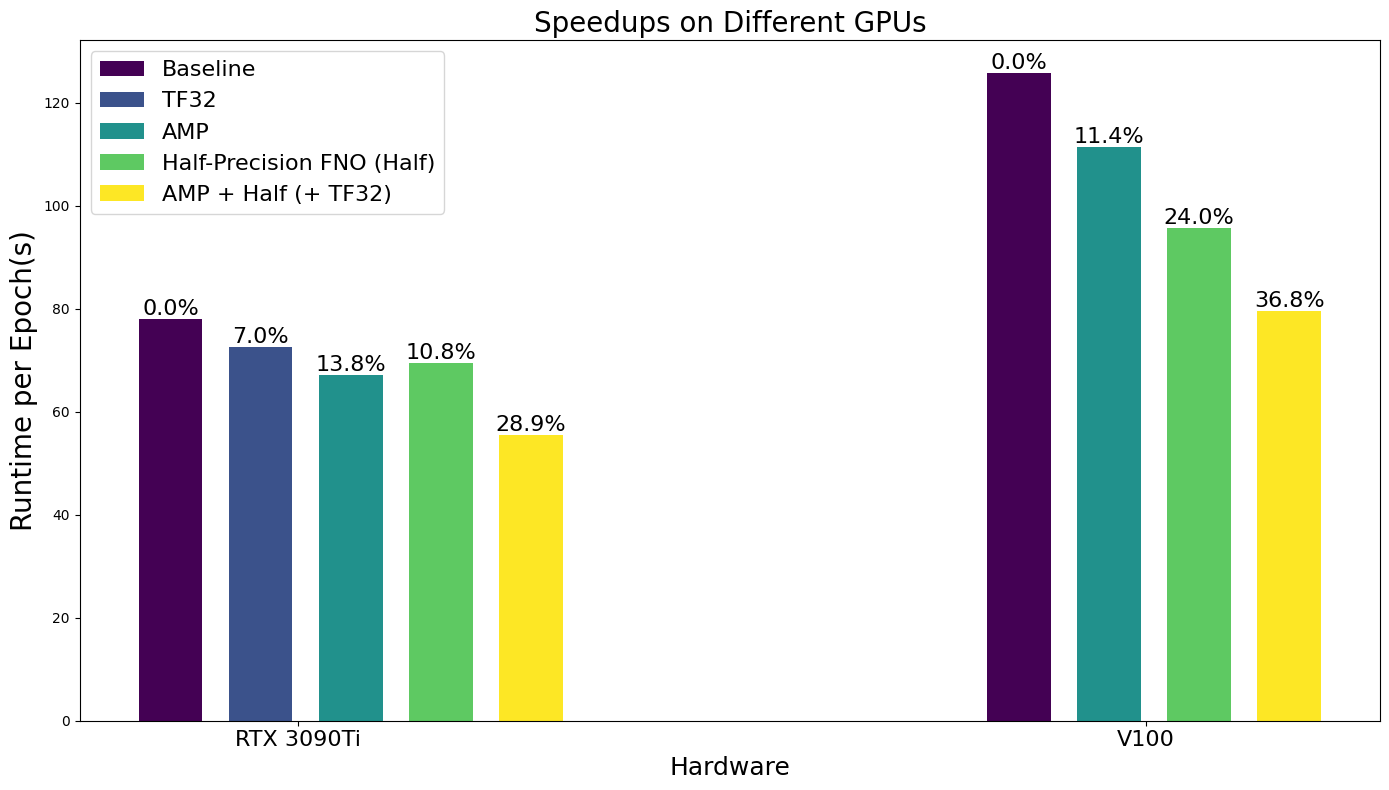

In [12]:
def plot_runtimes_hardware(runtimes_3090, runtimes_v100, labels_3090, labels_v100, save_name=None):
    plt.figure(figsize=(14, 8))

    num_methods = len(labels_3090)
    num_hardware = 2
    
    bar_width = 0.06
    colors = plt.cm.get_cmap('viridis', len(labels_3090))
    hardware_labels = ['RTX 3090Ti', 'V100']
    index = np.arange(num_hardware)

    # Plot each method's bars with distinct color
    for i, runtimes in enumerate(runtimes_3090):
        bars = plt.bar(i * bar_width+ 0.025*i, runtimes, bar_width, label=labels_3090[i], color=colors(i))
        for i, bar in enumerate(bars):
            height = bar.get_height()
            plt.text(bar.get_x() + bar.get_width() / 2, height,
                     f'{(runtimes_3090[i]-height)/runtimes_3090[i]*100:.1f}%', ha='center', va='bottom', fontsize=16)
    
    for i, runtimes in enumerate(runtimes_v100):
        if i:
            color_index = i + 1
        else:
            color_index = i
        bars_v100 = plt.bar(0.8 + i * bar_width+ 0.025*i, runtimes, bar_width, color=colors(color_index))
        for i, bar in enumerate(bars_v100):
            height = bar.get_height()
            plt.text(bar.get_x() + bar.get_width() / 2, height,
                     f'{(runtimes_v100[i]-height)/runtimes_v100[i]*100:.1f}%', ha='center', va='bottom', fontsize=16)
    

    # Adjust x-ticks and labels
    plt.xticks(index * 0.8 + bar_width * (num_methods - 1) / 2, hardware_labels, rotation='horizontal', fontsize=16)
    plt.xlabel('Hardware', fontsize=18)
    plt.ylabel('Runtime per Epoch(s)', fontsize=20)
    plt.title('Speedups on Different GPUs', fontsize=20)
    plt.grid(False)
    plt.legend(fontsize=16)

    if save_name is not None:
        plt.savefig(save_name, bbox_inches='tight', format='pdf')

    plt.tight_layout()
    plt.show()

volta_runtimes = [125.83, 111.49, 95.63, 79.56]
ampere_runtimes = [77.95, 72.52, 67.16, 69.55, 55.45]
ampere_labels = ['Baseline', 'TF32', 'AMP', 'Half-Prec FNO(Half)', 'AMP + Half (+ TF32)']
volta_labels = ['Baseline', 'AMP', 'Half-Prec FNO(Half)', 'AMP + Half']


plot_runtimes_hardware(ampere_runtimes, volta_runtimes, ['Baseline', 'TF32', 'AMP', 'Half-Precision FNO (Half)', 'AMP + Half (+ TF32)'], ['Baseline', 'AMP', 'Half-Precision FNO (Half)', 'AMP + Half'],
                       save_name='ampere_vs_volta_speed.pdf')

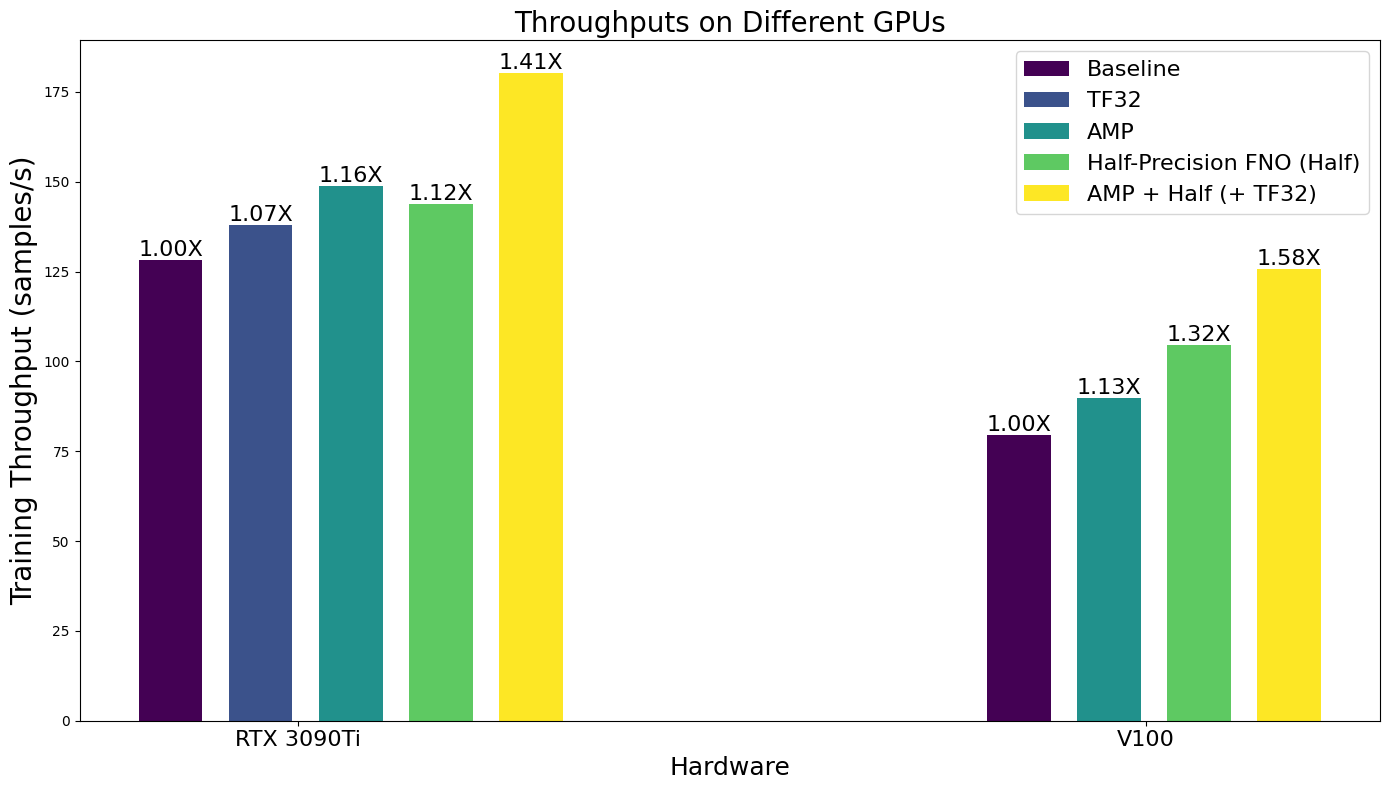

In [11]:
def plot_throughput_hardware(throughput_3090, throughput_v100, labels_3090, labels_v100, save_name=None):

    plt.figure(figsize=(14, 8))

    num_methods = len(labels_3090)
    num_hardware = 2
    
    bar_width = 0.06
    colors = plt.cm.get_cmap('viridis', len(labels_3090))
    hardware_labels = ['RTX 3090Ti', 'V100']
    index = np.arange(num_hardware)

    # Plot each method's bars with distinct color
    for i, runtimes in enumerate(throughput_3090):
        bars = plt.bar(i * bar_width+ 0.025*i, runtimes, bar_width, label=labels_3090[i], color=colors(i))
        for i, bar in enumerate(bars):
            height = bar.get_height()
            plt.text(bar.get_x() + bar.get_width() / 2, height,
                     f'{1+(height-throughput_3090[i])/throughput_3090[i]:.2f}X', ha='center', va='bottom', fontsize=16)
    
    for i, runtimes in enumerate(throughput_v100):
        if i:
            color_index = i + 1
        else:
            color_index = i
        bars_v100 = plt.bar(0.8 + i * bar_width+ 0.025*i, runtimes, bar_width, color=colors(color_index))
        for i, bar in enumerate(bars_v100):
            height = bar.get_height()
            plt.text(bar.get_x() + bar.get_width() / 2, height,
                     f'{1+(height-throughput_v100[i])/throughput_v100[i]:.2f}X', ha='center', va='bottom', fontsize=16)
    

    # Adjust x-ticks and labels
    plt.xticks(0.8 * index + bar_width * (num_methods - 1) / 2, hardware_labels, rotation='horizontal', fontsize=16)
    plt.xlabel('Hardware', fontsize=18)
    plt.ylabel('Training Throughput (samples/s)', fontsize=20)
    plt.title('Throughputs on Different GPUs', fontsize=20)
    plt.grid(False)
    plt.legend(fontsize=16)

    if save_name is not None:
        plt.savefig(save_name, bbox_inches='tight', format='pdf')

    plt.tight_layout()
    plt.show()

volta_runtimes = [125.83,  111.49, 95.63, 79.56]
ampere_runtimes = [77.95, 72.52, 67.16, 69.55, 55.45]
ampere_throughput = 10000 / np.array(ampere_runtimes)
volta_throughput = 10000 / np.array(volta_runtimes)
ampere_labels = ['Baseline', 'TF32', 'AMP', 'Half-Prec FNO(Half)', 'AMP + Half']
volta_labels = ['Baseline', 'AMP', 'Half-Prec FNO(Half)', 'AMP + Half']


plot_throughput_hardware(ampere_throughput, volta_throughput, ['Baseline', 'TF32', 'AMP', 'Half-Precision FNO (Half)', 'AMP + Half (+ TF32)'], ['Baseline', 'AMP', 'Half-Precision FNO (Half)', 'AMP + Half'],
                         save_name='ampere_vs_volta_throughput.pdf')